# CS986FoMLDAGroup12 Classification Problem

Amogh Patil 202186255<br>
Tahnia Sabah 202160537<br>
John Were 202151881<br>
Lisa Fulton 202184799<br>
Muhammad Umar Janjua 202169077 <br>

Spotify is one of the largest music streaming service providers, which is currently extremly popular amongst music enthusiasts. For this assignment we are building a classification model that can identify whether a song belongs to a particular genre. The dataset used for the classification problem is the adapted Spotify playlist dataset.<br>

Our notebook shows how a typical classification problem can be handled. We start by exploring the data, understanding the data, preparing the data, and visualising the distributions of features. We have also checked the correlations between the features using a heatmap and the multicollinearity using Variance Inflation Factor (VIF). Then we moved on to using Logistic Regression, a Random Forest classifier, Decision Tree classifier, and a Support Vector Classifier to check and compare their performance.

## Data Exploration

In [1]:
#!pip install missingno
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import missingno as msno
from sklearn.metrics import confusion_matrix, classification_report
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

In [2]:
df_train = pd.read_csv('CS98XClassificationTrain.csv')
df_test = pd.read_csv('CS98XClassificationTest.csv')

In [3]:
df_train.head()

,Id,title,artist,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop,top genre
0,1,My Happiness,Connie Francis,1996,107,31,45,-8,13,28,150,75,3,44,adult standards
1,2,Unchained Melody,The Teddy Bears,2011,114,44,53,-8,13,47,139,49,3,37,NaN
2,3,How Deep Is Your Love,Bee Gees,1979,105,36,63,-9,13,67,245,11,3,77,adult standards
3,4,Woman in Love,Barbra Streisand,1980,170,28,47,-16,13,33,232,25,3,67,adult standards
4,5,Goodbye Yellow Brick Road - Remastered 2014,Elton John,1973,121,47,56,-8,15,40,193,45,3,63,glam rock


The training dataset has 15 columns with 453 instances. Three of the columns are categorical and the rest are numerical. The column 'top genre' is our target column.

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453 entries, 0 to 452
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Id         453 non-null    int64 
 1   title      453 non-null    object
 2   artist     453 non-null    object
 3   year       453 non-null    int64 
 4   bpm        453 non-null    int64 
 5   nrgy       453 non-null    int64 
 6   dnce       453 non-null    int64 
 7   dB         453 non-null    int64 
 8   live       453 non-null    int64 
 9   val        453 non-null    int64 
 10  dur        453 non-null    int64 
 11  acous      453 non-null    int64 
 12  spch       453 non-null    int64 
 13  pop        453 non-null    int64 
 14  top genre  438 non-null    object
dtypes: int64(12), object(3)
memory usage: 53.2+ KB


This shows that 'top genre' has 15 missing values.

In [5]:
df_train.isna().sum()

Id            0
title         0
artist        0
year          0
bpm           0
nrgy          0
dnce          0
dB            0
live          0
val           0
dur           0
acous         0
spch          0
pop           0
top genre    15
dtype: int64

We have used the 'missingno' library to better visualise the missing value column.

<AxesSubplot:>

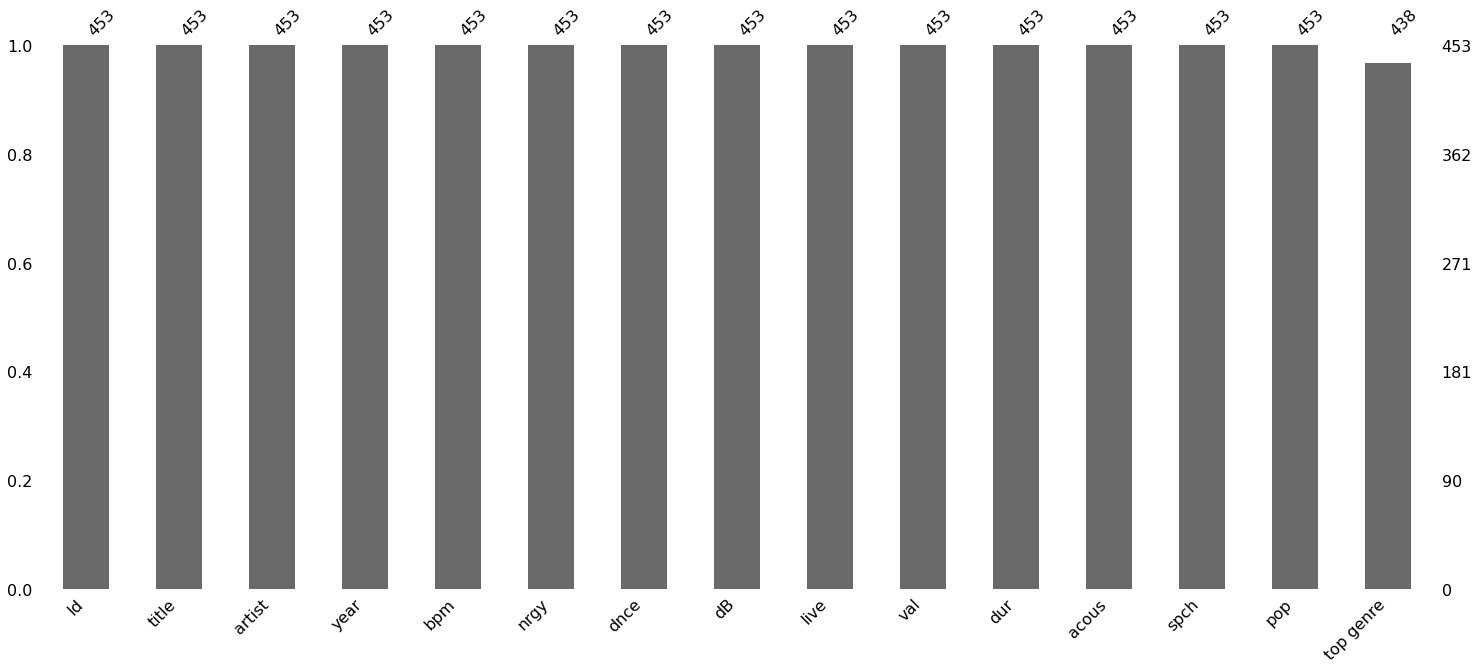

In [6]:
msno.bar(df_train)

There are different ways of handling missing values. We have opted not to drop the rows to avoid data loss in our train dataset and rather adopted data imputation. We are using the mode value of the 'top genre' column to fill the missing values.

In [7]:
df_train.fillna(df_train['top genre'].mode()[0],inplace=True)

### Checking for outliers

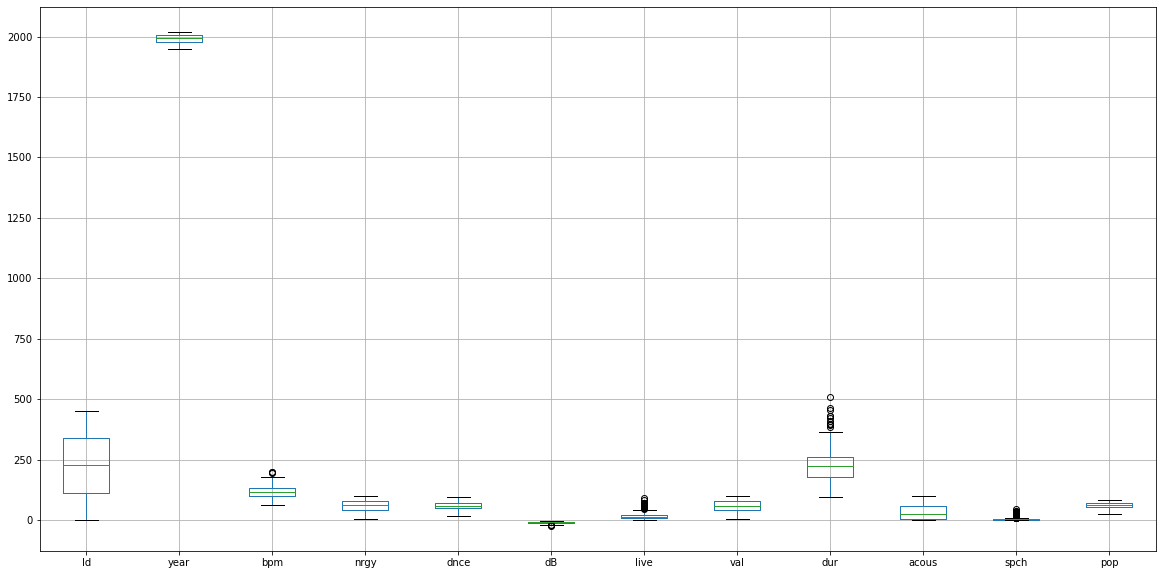

In [8]:
plt.figure(figsize=(20,10))
df_train.boxplot()
plt.show()

In [9]:
def remove_outliers(col):
    sorted(col)
    Q1,Q3 = np.percentile(col, [25,75])
    IQR = Q3 - Q1
    lower_bound =  Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 *IQR
    return lower_bound, upper_bound

In [10]:
des_columns = ["bpm",'dnce',"dB","dur","spch","pop","live"]

Rather than keeping the outliers, we have decided to handle them using the IQR method as we noticed that it increased the accuracy of our model by 0.2<br>

The IQR method identifies outliers by defining limits on the sample values that are a factor k of the IQR below the 25th percentile or above the 75th percentile. A common value for the factor k is the value 1.5.

In [11]:
for column in des_columns:
    lr,ur = remove_outliers(df_train[column])
    df_train[column] =np.where(df_train[column]>ur, ur, df_train[column])
    df_train[column] =np.where(df_train[column]<lr, lr, df_train[column])

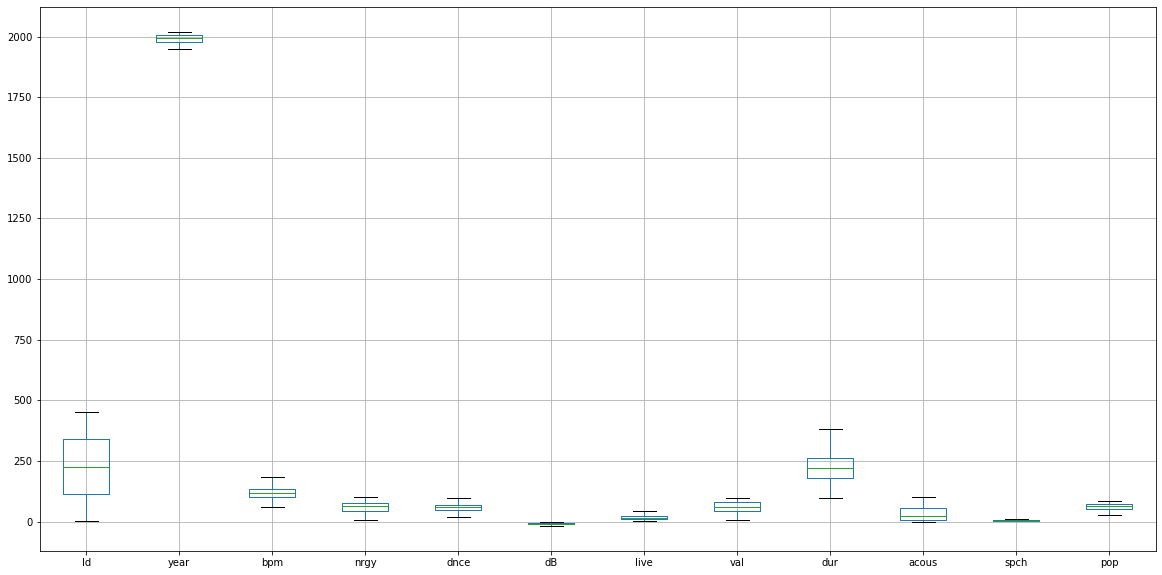

In [12]:
plt.figure(figsize=(20,10))
df_train.boxplot()
plt.show()

Initially we planned to keep the artist column as the information could be valuable for classification. For example, most Justin Bieber songs are of the 'pop' genre. We tried One-Hot Encoding the 'artist' column since it is categorical, but we had a mismatch with the train set compared to our test data, so we removed the artists from train data that are not present in the test data set. With this model, we got a better accuracy, which is 0.695 and f1 score was 1. However, the csv file generated by this model didn't perform well in Kaggle. We had also tried to keep the 'artist' by label encoding it. With this model the score in Kaggle was even worse. So, we chose to drop the 'artist' column.

We drop 'Id', 'title', and 'Artist' columns, with the assumption that 'Id' and 'title' don't provide valuable information regarding genre prediction.

In [13]:
df_train = df_train.drop('Id',axis=1)
df_train = df_train.drop('title',axis=1)
df_train = df_train.drop('artist',axis=1)

We checked the distribution of few of the features in the dataset.<br>

<AxesSubplot:xlabel='bpm', ylabel='Density'>

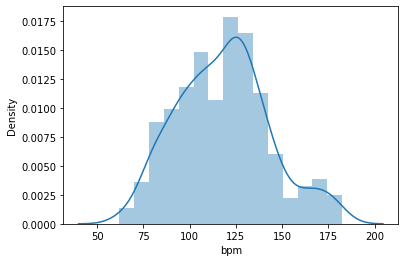

In [14]:
sns.distplot(df_train['bpm'])

This distribution plot shows that the bpm of most of the songs in the dataset seem to be around 100 to around 130.

<AxesSubplot:xlabel='nrgy', ylabel='Density'>

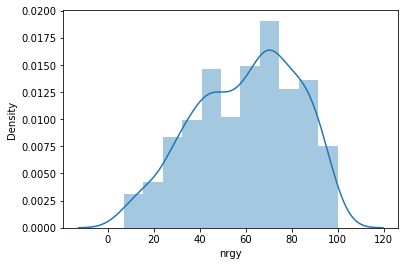

In [15]:
sns.distplot(df_train['nrgy'])

This distribution plot shows that the energy of most of the songs in the dataset seem to be around 40 to around 90.

<AxesSubplot:xlabel='dnce', ylabel='Density'>

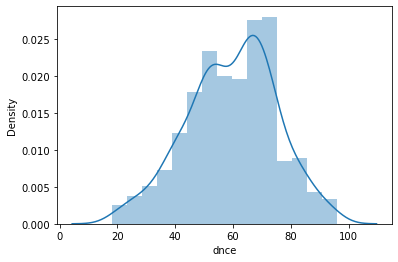

In [16]:
sns.distplot(df_train['dnce'])

This plot, and the one above suggests that most of the songs are more 'upbeat'. 

## Visualising some key attributes

We used a histogram of the attributes to get a better understanding of the data.<br>

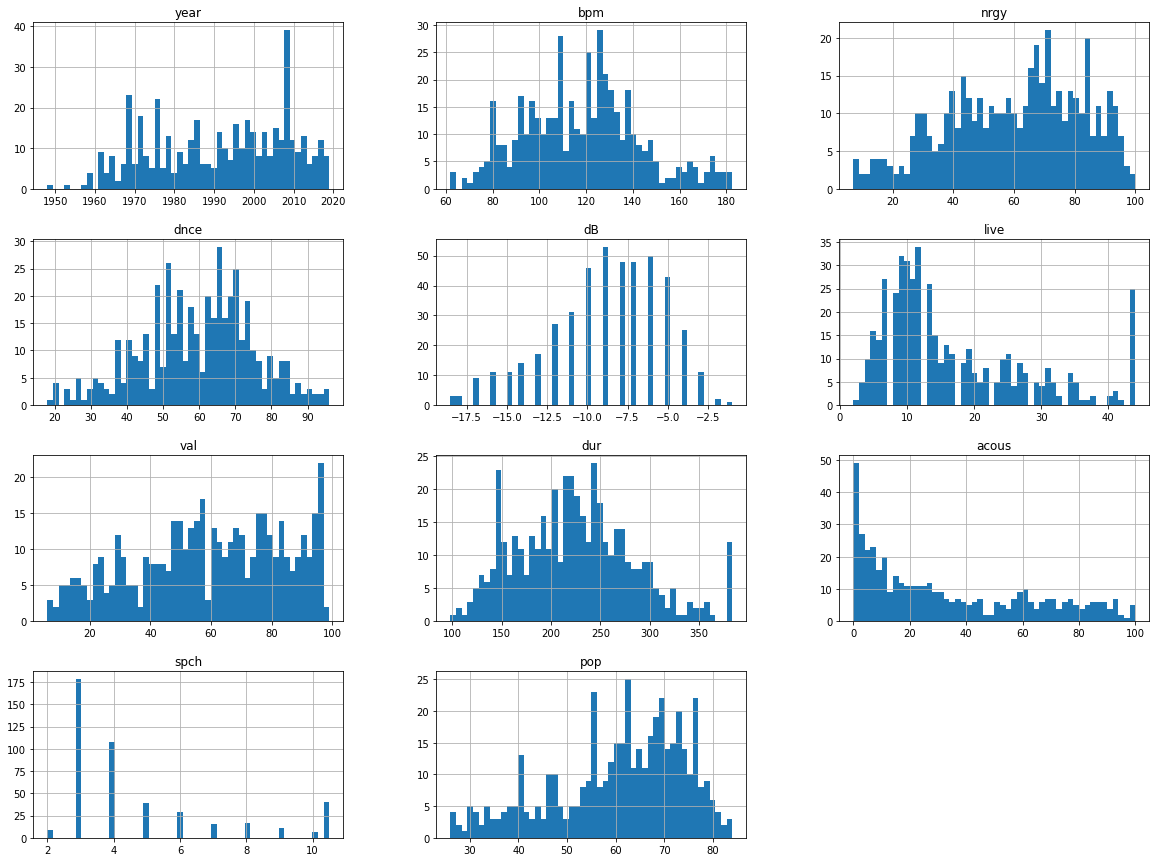

In [17]:
df_train.hist(bins=50,figsize=(20,15))
plt.show()

The correlation matrix for numeric variables is shown in the heatmap below.<br>

This heatmap helps us to understand which attributes are correlated by visualising the possible relationships within the dataset. Based on this, the columns 'title', 'artist', and 'Id' were removed from the dataset.

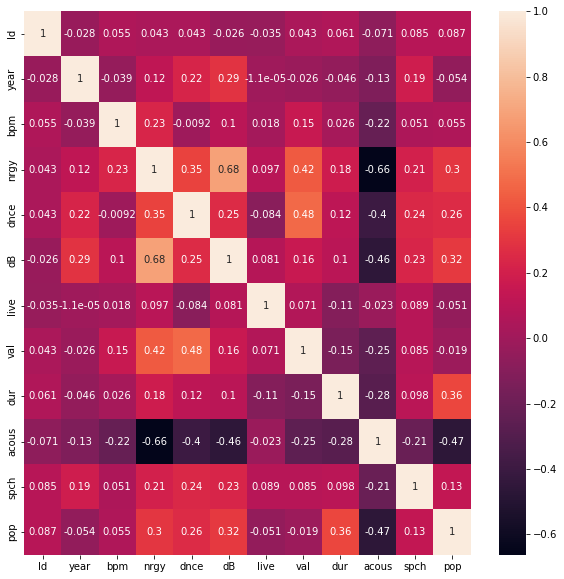

In [4]:
plt.figure(figsize=(10,10))
sns.heatmap(df_train.corr(),annot=True)
plt.show()

We have added a histogram of the predict column 'top genre'. Most songs in the train set belong to the 'adult standards', 'album rock', and 'dance pop' genres.

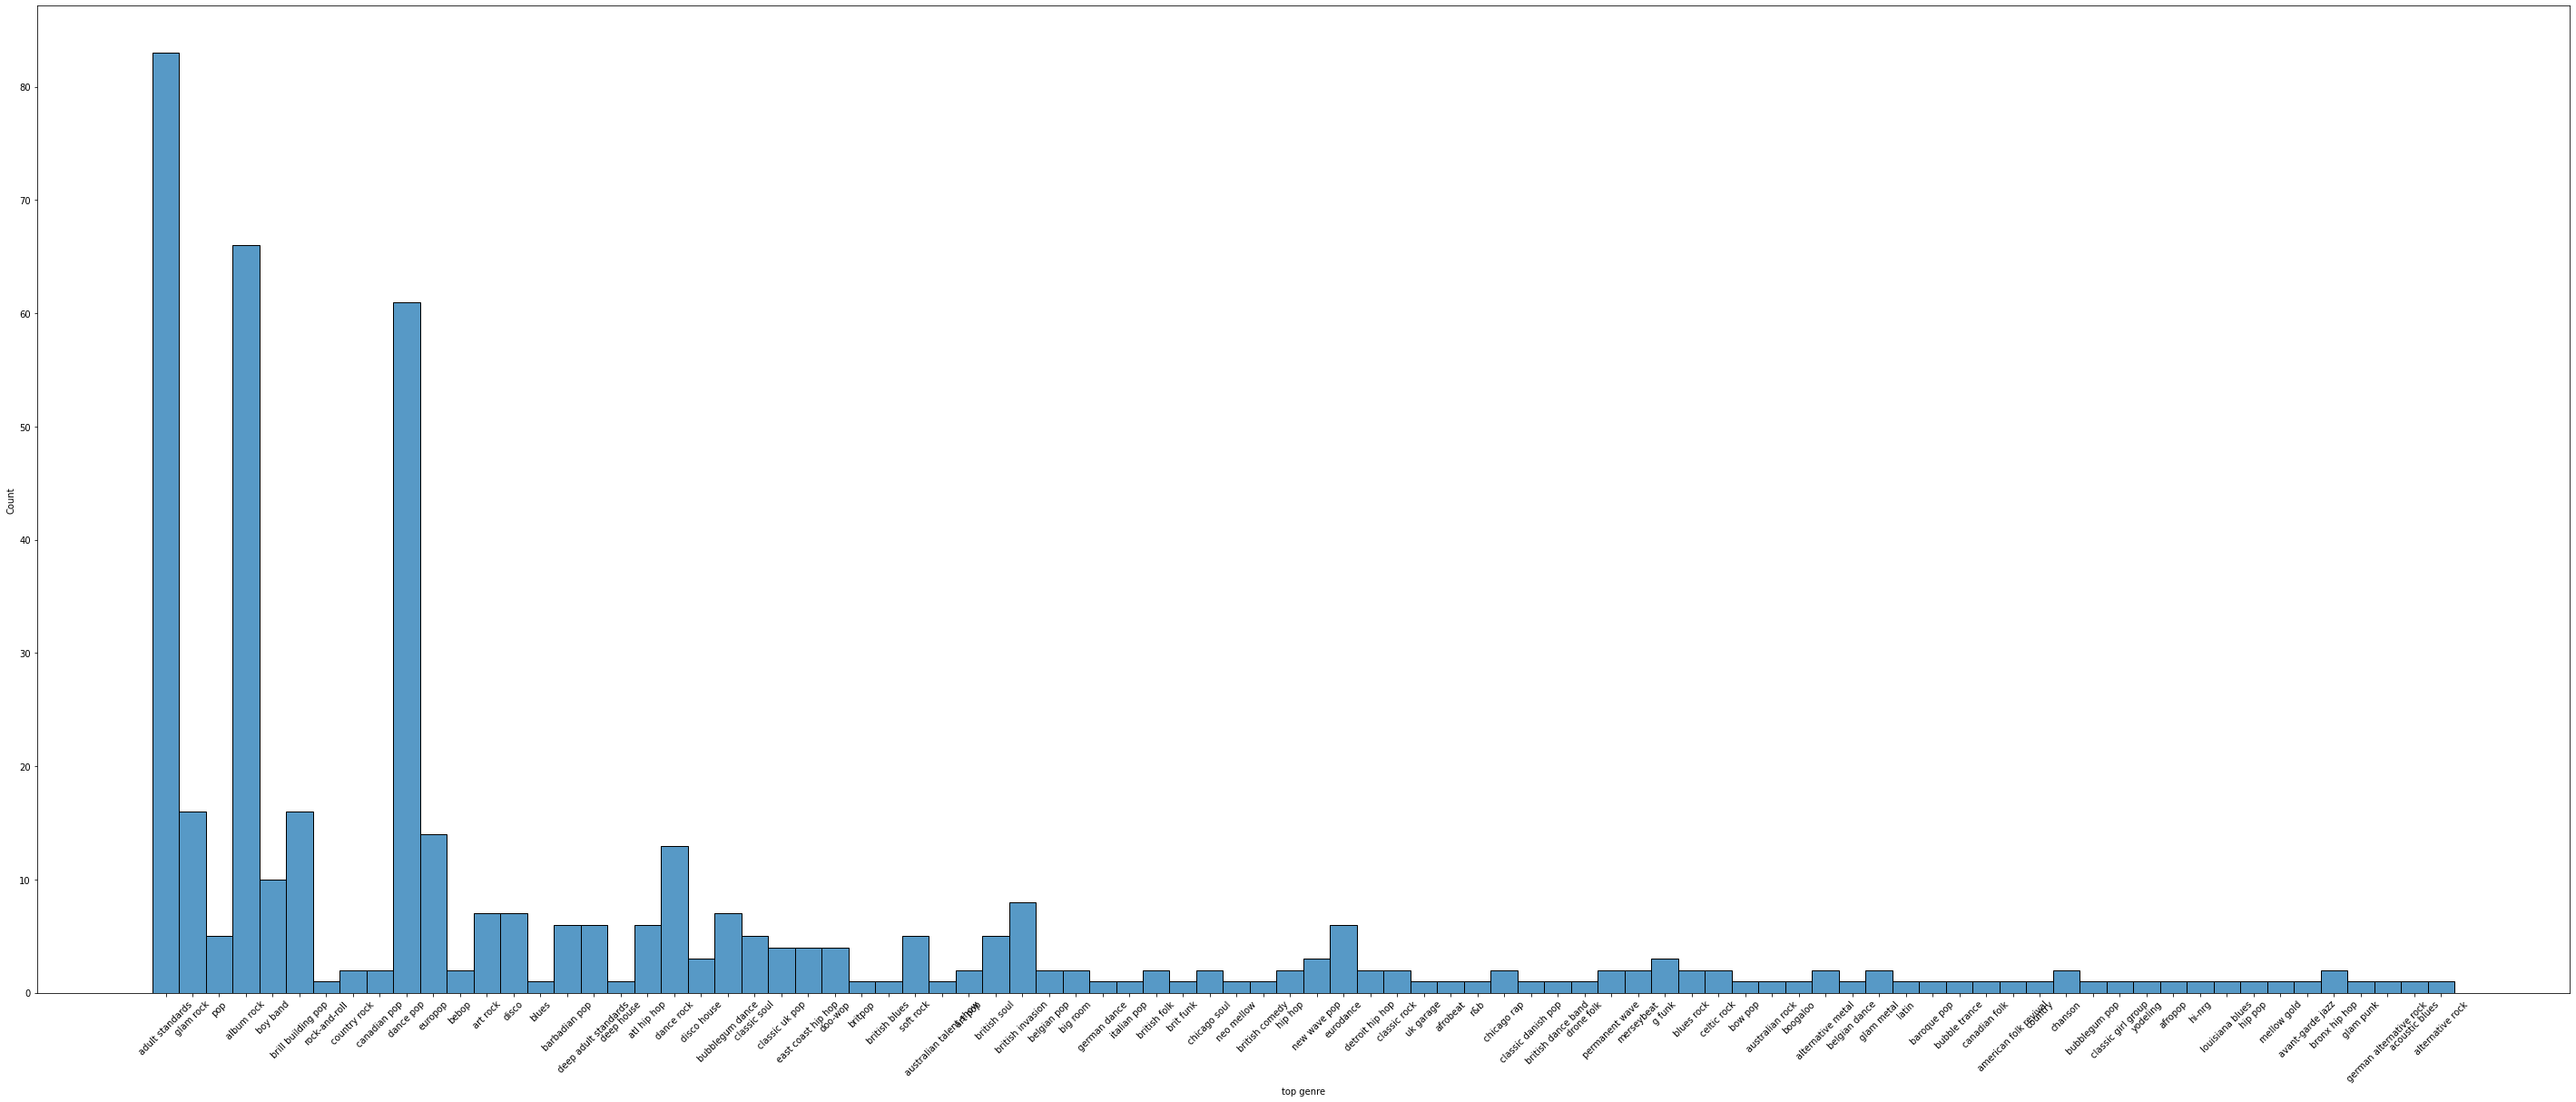

In [19]:
plt.figure(figsize=(50,20))
sns.histplot(df_train['top genre'])
plt.xticks(rotation=45)
plt.show()

We then made a pair-plot to visualise the best set of features to explain a relationship between two attributes. Unfortunately, we didn't find any significant relation here between any two attributes.

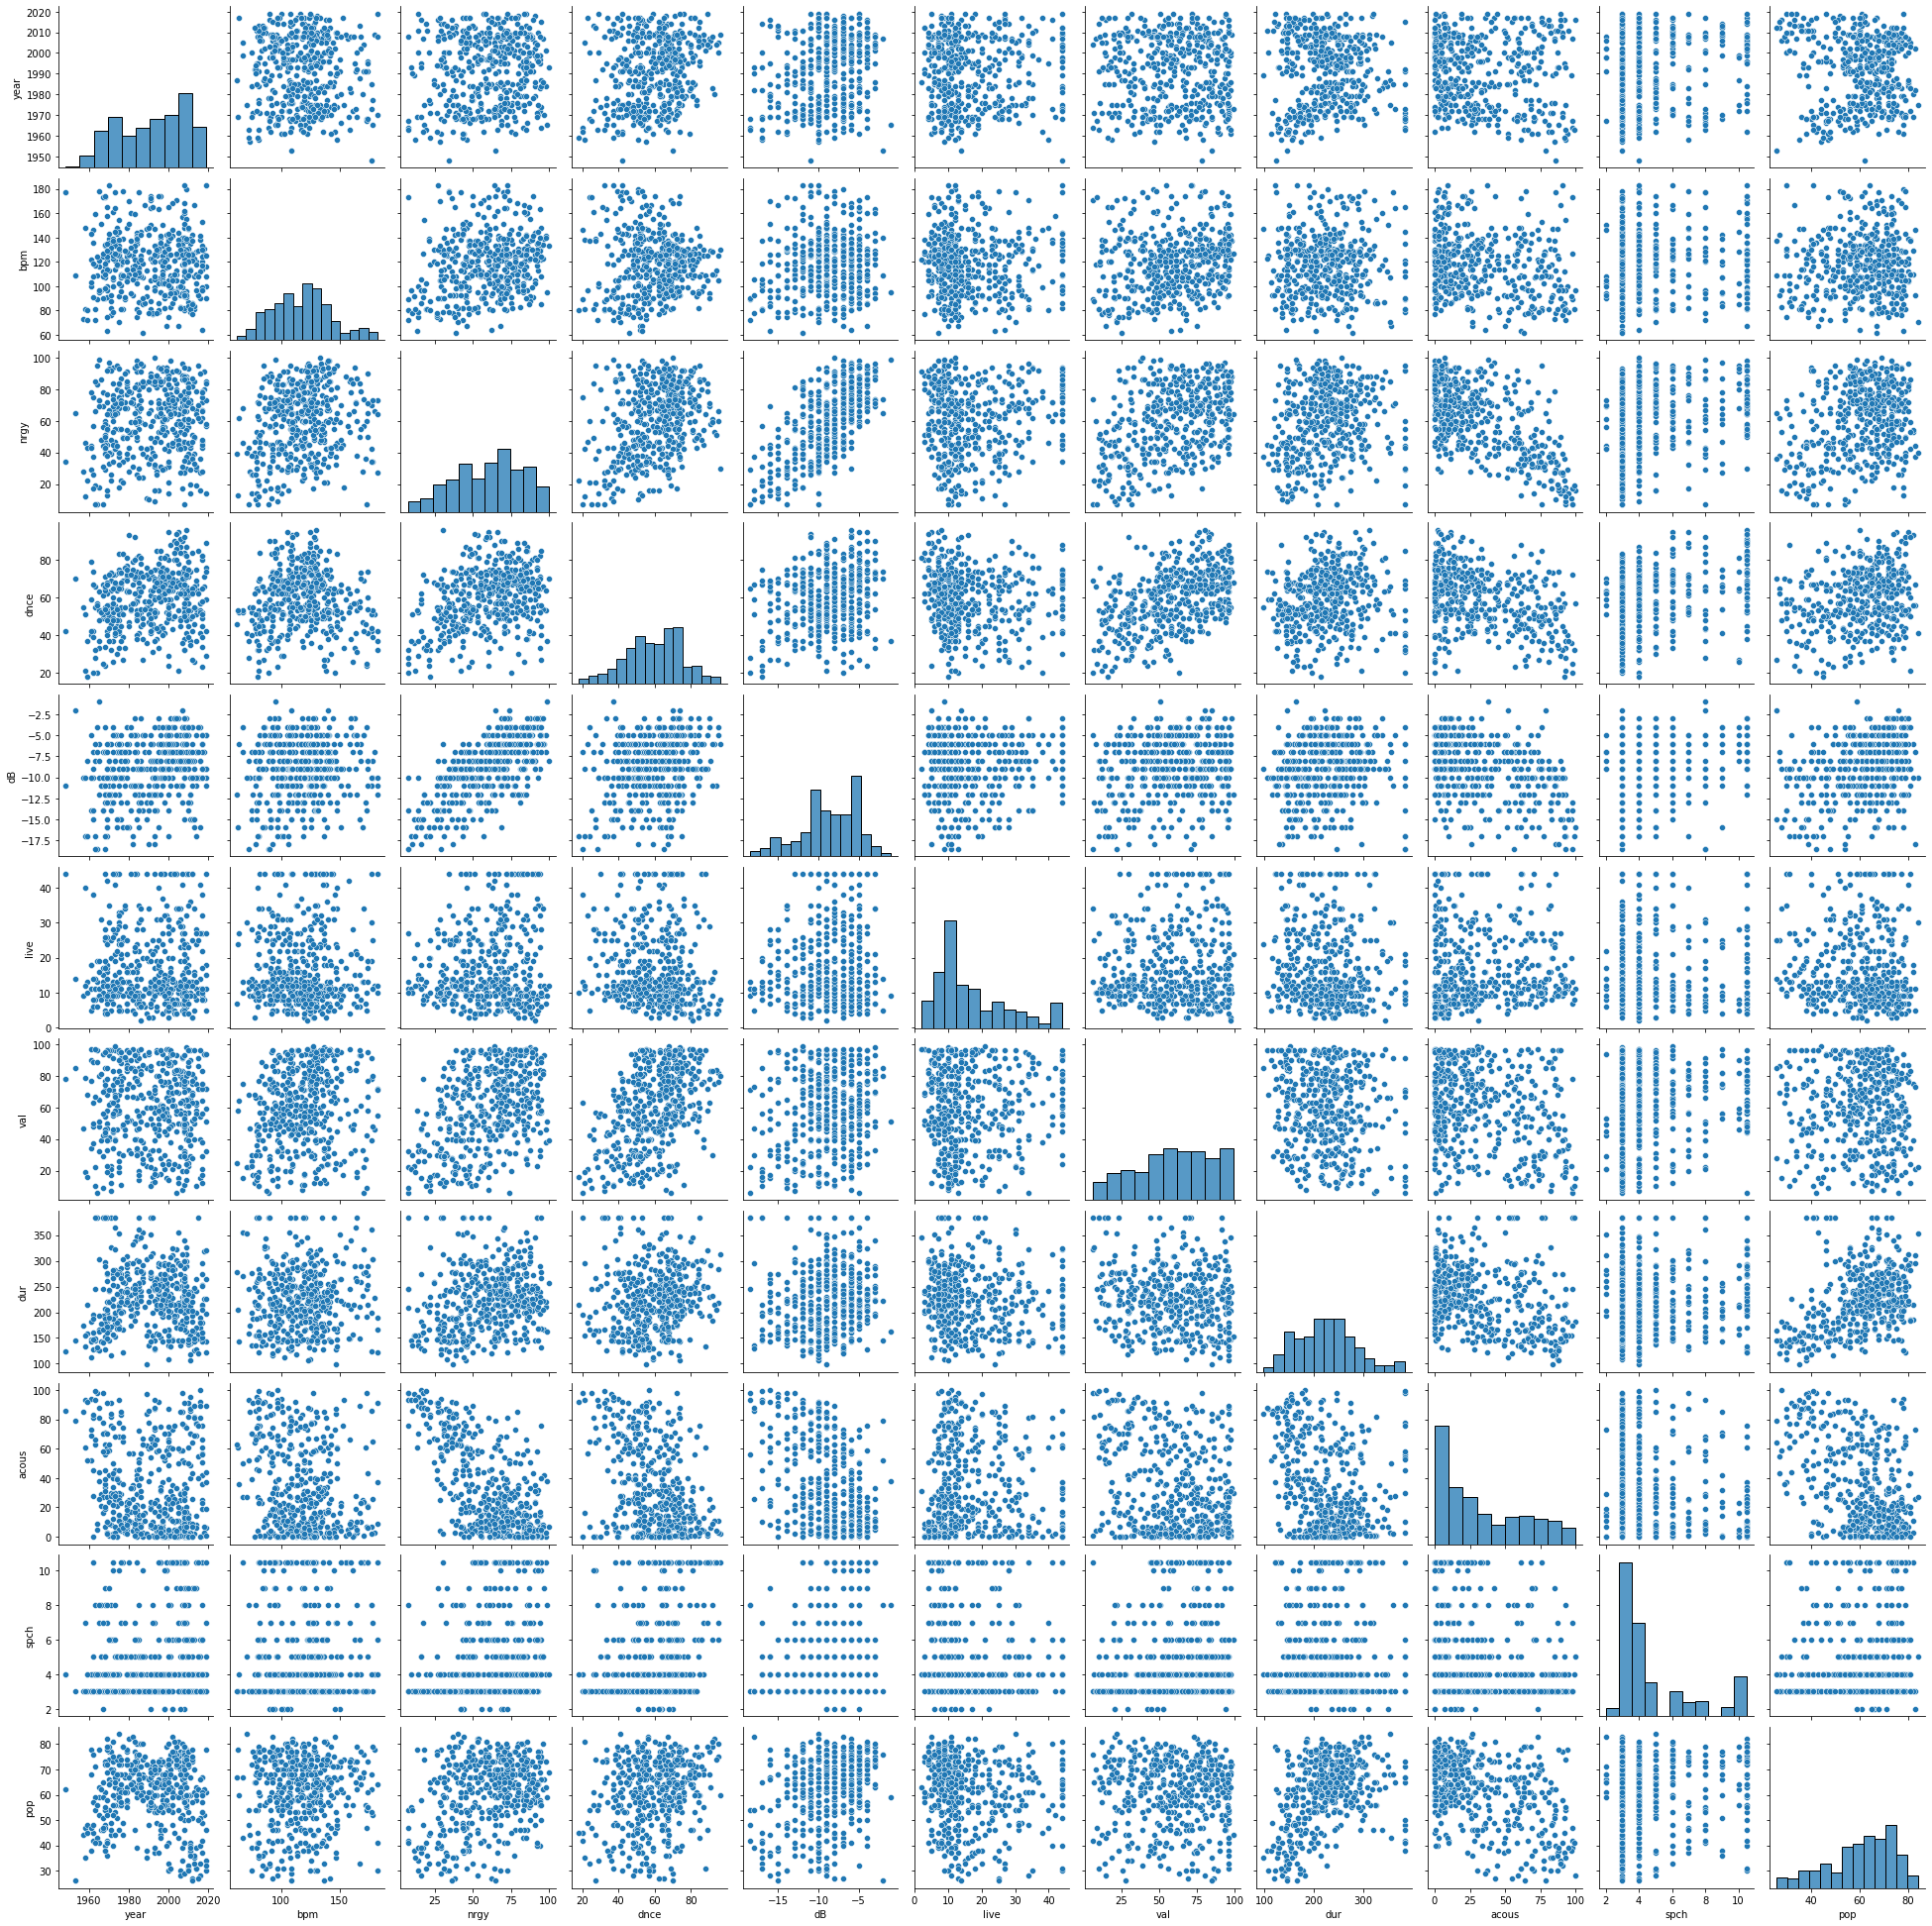

In [20]:
sns.pairplot(df_train)

## Data Preparation

We used Label Encoder with 'top genre' since it is the predict column and the number of instances in the dataset is quite large. One-Hot Encoding should be avoided in this case as it can lead to high memory consumption.

In [21]:
le = LabelEncoder()
df_train['top genre'] = le.fit_transform(df_train['top genre'])

# Creating the test set

### Splitting The Data

In [22]:
X = df_train.drop('top genre',axis=1)
y = df_train['top genre']

The dataset we are using is quite small, so we have selected 0.3 as test size after testing the model with different split sizes.

In [23]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)

### Scaling The Data

Variables assessed at different scales may not contribute equally to the model fitting and learning function, which might lead to bias. So, we have used StandardScaler to standardise the numerical data to ensure a normal distribution.

In [24]:
standard_scaler = StandardScaler()
standard_scaler.fit(X_train)
X_train_ST = standard_scaler.transform(X_train)
X_test_ST = standard_scaler.transform(X_test)

### Variance inflation factor

Using Variance Inflation Factor we can see high correlations that we couldn't see from the heatmap.

In [25]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calc_vif(X):
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)
calc_vif(df_train)

,variables,VIF
0,year,153.298727
1,bpm,25.956569
2,nrgy,27.018985
3,dnce,27.985948
4,dB,14.761275
5,live,3.608373
6,val,12.059461
7,dur,19.630261
8,acous,4.979480
9,spch,5.614992


## Classification

### Logistic Regression

We use Logistic regression with 'One Versus Rest' for multi-class classification. We also use Grid Search to find the best value for the parameters.<br>

We decided to use Gridsearch only with this algorithm as it gave us the best accuracy result but chose not to include it in other algorithms as it is computationally heavy.

In [26]:
from sklearn.model_selection import GridSearchCV
log_reg = LogisticRegression()
parameters = {'penalty':('l1', 'l2', 'elasticnet', 'none'), 'C':[1, 10], 'solver':('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'),'multi_class':('auto', 'ovr', 'multinomial')}
log_clf = GridSearchCV(log_reg, parameters)
log_clf.fit(X_train_ST,y_train)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [1, 10],
                         'multi_class': ('auto', 'ovr', 'multinomial'),
                         'penalty': ('l1', 'l2', 'elasticnet', 'none'),
                         'solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga')})

In [27]:
#log_reg.fit(X_train_ST,y_train)
y_pred_log = log_clf.predict(X_test_ST)
accuracy_score(y_test,y_pred_log)

0.375

### Decision Tree

This is a supervised learning technique most commonly employed for classification problems. It builds a 'tree' based on the training data, then uses this to make decisions on what class a new instance belongs to.

In [29]:
dtc = DecisionTreeClassifier(max_depth=5)
dtc.fit(X_train_ST,y_train)
y_pred_dt = dtc.predict(X_test_ST)
accuracy_score(y_test,y_pred_dt)

0.35294117647058826

### Random Forest

The Random Forest is an ensemble comprised of Decision Trees. It also adds randomness to the model which helps lower variance. It necessitates a significant amount of computer power because it constructs several trees and combines their outcomes.

In [28]:
rand_forest = RandomForestClassifier(random_state = 1, min_samples_split = 5, criterion='entropy',max_features='log2')
rand_forest.fit(X_train_ST,y_train)
y_pred_rand = rand_forest.predict(X_test_ST)
accuracy_score(y_test,y_pred_rand)

0.3897058823529412

### Voting Classifier

This trains various base models and predicts on the basis of aggregating the findings of each base estimator.

In [30]:
voting_clf = VotingClassifier(estimators=[('lr', log_reg), ('rf', rand_forest),('dtc',dtc)],voting='hard')
voting_clf.fit(X_train_ST,y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf',
                              RandomForestClassifier(criterion='entropy',
                                                     max_features='log2',
                                                     min_samples_split=5,
                                                     random_state=1)),
                             ('dtc', DecisionTreeClassifier(max_depth=5))])

In [31]:
for clf in (log_reg, rand_forest,dtc, voting_clf):
    clf.fit(X_train_ST, y_train)
    ypred = clf.predict(X_test_ST)
    print(clf.__class__.__name__, accuracy_score(y_test, ypred))

LogisticRegression 0.38235294117647056
RandomForestClassifier 0.3897058823529412
DecisionTreeClassifier 0.35294117647058826
VotingClassifier 0.40441176470588236


### Test Data

In [33]:
c_matrix = confusion_matrix(y_test,y_pred_log)
print(c_matrix)

[[21  0  4 ...  0  0  0]
 [ 0  0  1 ...  0  0  0]
 [ 3  0 14 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  1 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


In [34]:
print(classification_report(y_test,y_pred_log))

              precision    recall  f1-score   support

           1       0.41      0.78      0.54        27
           3       0.00      0.00      0.00         1
           4       0.34      0.78      0.47        18
           9       0.00      0.00      0.00         3
          10       0.00      0.00      0.00         3
          14       0.00      0.00      0.00         3
          16       0.00      0.00      0.00         2
          23       0.00      0.00      0.00         1
          24       0.00      0.00      0.00         4
          25       0.00      0.00      0.00         4
          26       0.00      0.00      0.00         1
          27       0.00      0.00      0.00         1
          30       0.00      0.00      0.00         2
          31       0.00      0.00      0.00         2
          32       0.00      0.00      0.00         1
          33       0.00      0.00      0.00         1
          35       0.00      0.00      0.00         1
          36       0.00    

In [35]:
df_test.head()

,Id,title,artist,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop
0,454,Pump It,The Black Eyed Peas,2005,154,93,65,-3,75,74,213,1,18,72
1,455,"Circle of Life - From ""The Lion King""/Soundtra...",Elton John,1994,161,39,30,-15,11,14,292,26,3,59
2,456,We Are The Champions - Remastered 2011,Queen,1977,64,46,27,-7,12,18,179,38,3,76
3,457,Insomnia - Radio Edit,Faithless,2010,127,92,71,-9,37,53,216,6,4,50
4,458,This Eve of Parting,John Hartford,2018,115,46,56,-12,21,34,153,18,3,44


For our test dataset we have removed the outliers, scaled the data, and dropped 'id', 'title', and 'artist' columns.

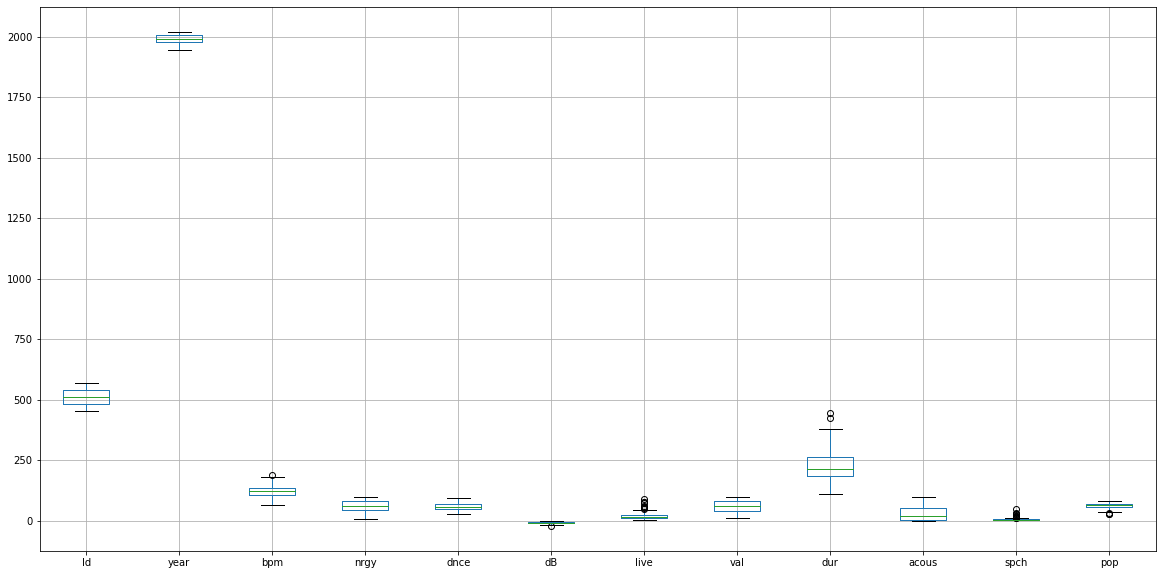

In [36]:
plt.figure(figsize=(20,10))
df_test.boxplot()
plt.show()

In [37]:
for column in des_columns:
    lr,ur = remove_outliers(df_test[column])
    df_test[column] =np.where(df_test[column]>ur, ur, df_test[column])
    df_test[column] =np.where(df_test[column]<lr, lr, df_test[column])

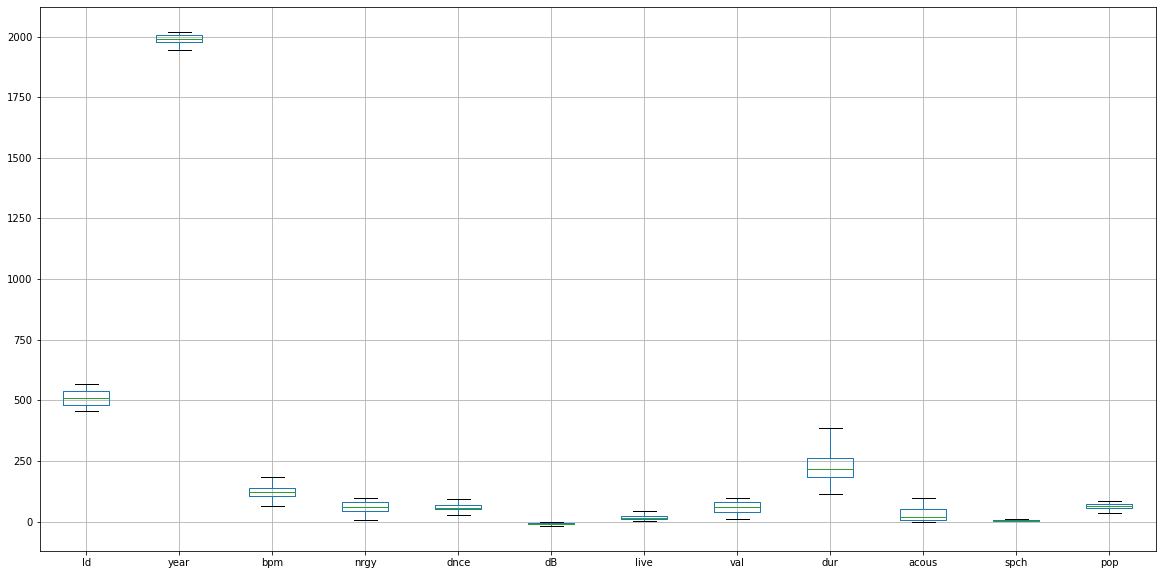

In [38]:
plt.figure(figsize=(20,10))
df_test.boxplot()
plt.show()

In [39]:
Id = df_test.iloc[:,0].values
df_test = df_test.drop('Id',axis=1)
df_test = df_test.drop('title',axis=1)
df_test = df_test.drop('artist',axis=1)

In [40]:
X_test_1 = standard_scaler.transform(df_test)

In [41]:
df_test_pred = log_clf.predict(X_test_1)

In [42]:
Result = pd.DataFrame()
Result['Id']= Id
Result['top genre'] = pd.DataFrame(le.inverse_transform(df_test_pred))
Result.to_csv('Result_scale_lr_wo_pca_with_GS_removing_outlier_vif.csv', index= False)

## Conclusion

To evaluate the classification models, the accuracy of each method was obtained and compared. The best method was the Voting Classifier with an accuracy score of 0.40. For submission we opted to use Logistic Regression as it gave us a better score in Kaggle. The model used for the submission to Kaggle initially scored 0.33928. The final Kaggle result was a slight improvement at 0.38596.

Implementing clustering into the data preprocessing pipeline would likely have resulted in fewer labels and an increased accuracy score. For future work we'd like to investigate how to implement this technique successfully and also adapt the model with hyper-parameter tuning to investigate what effect this would have on the accuracy of each of the classification models. Some techniques into how we could alleviate overfitting on such a small dataset would likely be beneficial to the final classification score.

#### References

[1]A. Géron and R. Demarest, Hands-on machine learning with Scikit-Learn and TensorFlow. Sebastopol (Clif.) [etc.]: O'Reilly, 2019.

[2]"1.4. Support Vector Machines", scikit-learn, 2022. [Online]. Available: https://scikit-learn.org/stable/modules/svm.html#classification. [Accessed: 10- Feb- 2022].

[3]"1.10. Decision Trees", scikit-learn, 2022. [Online]. Available: https://scikit-learn.org/stable/modules/tree.html#classification. [Accessed: 11- Feb- 2022].

[4]"1.11. Ensemble methods", scikit-learn, 2022. [Online]. Available: https://scikit-learn.org/stable/modules/ensemble.html#voting-classifier. [Accessed: 12- Feb- 2022].

[5]"sklearn.ensemble.RandomForestClassifier", scikit-learn, 2022. [Online]. Available: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier. [Accessed: 14- Feb- 2022].